In [3]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
import numpy as np

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [6]:
import sys
sys.path.append(".")

In [7]:
from mc_plot_utils import MCMCResult

In [8]:
import mc_plot_utils

In [26]:
import cc_plot_utils

In [72]:
from scipy import interpolate

In [197]:
def print_ys_spline(model):
    median = model.samples.median()

    keys = [str(key) for key in median.keys() if key.startswith("spline") ]


    ys = []
    for i in range(len(keys)):
        param = median[f"spline_{i}"]
        ys.append(f"{param * 1e-3:0.2e}")

    s = str(ys)
    print(s.replace("'", ""))


In [198]:
print_ys_spline(results["fiducial_spline"])

[7.90e-04, 2.10e-03, 1.75e-03, 1.72e-03, 1.70e-03, 2.00e-03, 2.64e-03, 4.55e-03]


# Utilities

In [70]:
def load_model(filename, y_model, y_agb, test=False, burn=0):
  
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename + "/", burn=burn)

    result.y_model = y_model
    result.y_agb = y_agb
    return result

## CC utilites

In [50]:
y_cc_z0 = lambda z: 1e-3
y_cc_z1 = np.vectorize(lambda z: 1*y_z0(z) + surp.yield_models.Lin_CC(slope=0.001 / surp.Z_SUN, y0=0)(z))
y_cc_z2 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 2e-3, 1e-3]))
y_cc_z3 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 3e-3, 3e-3, 1e-3]))
y_cc_z4 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 4e-3, 6e-3, 4e-3, 1e-3]))
y_cc_z5 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 5e-3, 10e-3, 10e-3, 5e-3, 1e-3]))


In [63]:
def y_cc_lin(sample):
    y = lambda Z: sample.y0_cc * y_cc_z0(Z) + sample.zeta_cc * y_cc_z1(Z)
    return y

In [57]:
y_mg = vice.yields.ccsne.settings["mg"]

In [121]:
def y_cc_spline(sample, Zs = [0.000176, 0.00176, 0.00442092, 0.00700669, 0.01110485, 0.0176, 0.02789412, 0.0442092]):
    y = np.vectorize(1e-3 * surp.yield_models.Spline_CC(Zs, [sample[f"spline_{i}"] for i in range(len(Zs))]))
    return y

### Load up AGBS

In [23]:
agb_interpolator = surp.agb_interpolator.interpolator

In [24]:
surp.set_yields(surp.yield_params.YieldParams.from_file("../models/fiducial/best/yield_params.toml"))

In [56]:

Y_agbs = {
    "fruity": agb_interpolator("c"),
    "fruity_m0.7": agb_interpolator("c", mass_factor=0.7),
    "aton": agb_interpolator("c", study="ventura13"),
    "monash": agb_interpolator("c", study="karakas16"),
    "nugrid": agb_interpolator("c", study="pignatari16"),
    "analytic": surp.yield_models.C_AGB_Model(y0=1e-3, zeta=1e-3, tau_agb=1, t_D=0.15)
}

In [128]:
M_H_plot = np.linspace(-4.0, 0.5, 1000)
Z_plot = gcem.MH_to_Z(M_H)

surp.set_yields(verbose=False)
ys_fiducial = surp.yields.calc_y(Z)

y_agbs = {}
for key, Y_agb in Y_agbs.items():
    print(Y_agb)
    vice.yields.agb.settings["c"] = Y_agb
    ys_a = surp.yields.calc_y(Z_plot, kind="agb")
    
    y_agbs[key] = interpolate.interp1d(Z_plot, ys_a, fill_value="extrapolate")


1.00 × cristallo11
1.00 × cristallo11
1.00 × ventura13
1.00 × karakas16
1.00 × pignatari16
(1.00e-03 + 1.00e-03(Z-Zo)), t_D=0.15, tau=1.00


## Plot Utilities

In [25]:
def plot_yield(y, **kwargs):
    x = np.linspace(-2, 1, 1000)
    z = gcem.MH_to_Z(x)
    plt.plot(x, np.vectorize(y)(z), **kwargs)

# Load results

In [82]:
results = {}

In [83]:
results["fiducial"] = load_model("fiducial", y_cc_lin, y_agbs["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [123]:
results["fiducial_spline"] = load_model("fiducial_spline", y_cc_spline, y_agbs["fruity"])

adding  spline_0
length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'spline_0': {'name': 'perturbations/spline_0', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'spline_1': {'name': 'perturbations/spline_1', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_2': {'name': 'perturbations/spline_2', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_3': {'name': 'perturbations/spline_3', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_4': {'name': 'perturbations/spline_4', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_5': {'name': 'perturbations/spline_5', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_6': {'name': 'perturbations/spline_6', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'spline_7': {'name': 'perturbations/spline_7', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}}


In [140]:
results["fiducial_constrained"] = load_model("fiducial_constrained", y_cc_lin, y_agbs["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [86]:
results["aton"] = load_model("aton", y_cc_lin, y_agbs["aton"])

length of samples =  48000
{'alpha': {'name': 'perturbations/aton', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [87]:
results["monash"] = load_model("monash", y_cc_lin, y_agbs["monash"])

length of samples =  48000
{'alpha': {'name': 'perturbations/monash', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


# Plots

In [135]:
def plot_y_tot_mean(result, M_H=M_H_plot, y_z0=y_z0 , y_z1=y_z1,  **kwargs):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
        

    sample = samples.median()
    y_cc = result.y_model(sample)(Z)
    y_agb = result.y_agb(Z) * sample.alpha
    yt = y_agb + y_cc
        
    plt.plot(M_H_plot, yt / y_mg, **kwargs)


In [130]:
def plot_y_cc_mean(result, M_H=M_H_plot, y_z0=y_z0 , y_z1=y_z1,  **kwargs):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
        

    sample = samples.median()
    y_cc = result.y_model(sample)(Z)        
    plt.plot(M_H_plot, y_cc / y_mg, **kwargs)


In [173]:
def plot_y_tot(result, thin=1000, M_H=M_H_plot, color="black", alpha=None, label="", **kwargs):
    samples = result.samples

    if alpha is None:
        alpha = 1 / len(samples[::thin])**(1/3) / 10
        
    Z = gcem.MH_to_Z(M_H)

    for i, sample in samples[::thin].iterrows():
        y_cc = result.y_model(sample)(Z)
        y_agb = result.y_agb(Z) * sample.alpha
        yt = y_agb + y_cc
            
        plt.plot(M_H, yt / y_mg, color=color, alpha=alpha, rasterized=True, **kwargs)
    
    plt.plot([], [], color=color, alpha=0.5, label=label)
    



In [174]:
def plot_y_cc(result, thin=1000, M_H=M_H_plot, color="black", alpha=None, label="", **kwargs):
    samples = result.samples

    if alpha is None:
        alpha = 1 / len(samples[::thin])**(1/3) / 10
        
    Z = gcem.MH_to_Z(M_H)

    for i, sample in samples[::thin].iterrows():
        y_cc = result.y_model(sample)(Z)
            
        plt.plot(M_H, y_cc / y_mg, color=color, alpha=alpha, rasterized=True, **kwargs)
    

    plt.plot([], [], color=color, alpha=0.5, label=label)




In [163]:
def compare_y_tot_mean(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm tot} / y_{\rm Mg}$")

    for (key, label) in labels.items():
        plot_y_tot_mean(results[key], label=label)

    plt.legend()

    

In [165]:
def compare_y_cc_mean(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm CC} / y_{\rm Mg}$")

    for (key, label) in labels.items():
        plot_y_cc_mean(results[key], label=label)

    plt.legend()

    

In [167]:
def compare_y_tot(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm tot} / y_{\rm Mg}$")

    for (i, (key, label)) in enumerate(labels.items()):
        plot_y_tot(results[key], label=label, color=arya.COLORS[i])

    plt.legend()

    

In [168]:
def compare_y_cc(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm CC} / y_{\rm Mg}$")

    for (i, (key, label)) in enumerate(labels.items()):
        plot_y_cc(results[key], label=label, color=arya.COLORS[i])

    plt.legend()

    

['spline_2',
 'spline_1',
 'spline_6',
 'spline_7',
 'spline_4',
 'spline_3',
 'spline_5',
 'spline_0']

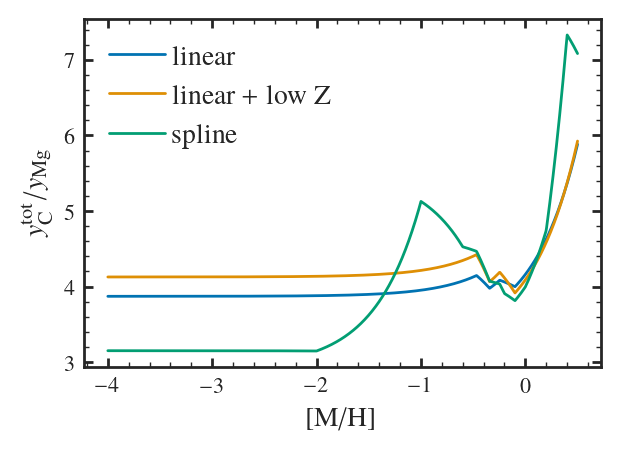

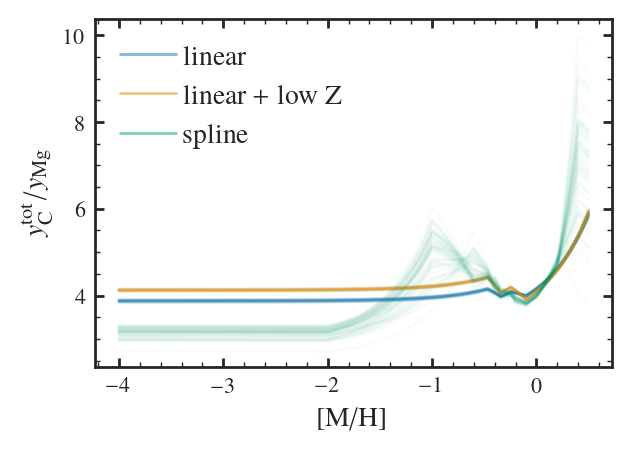

In [175]:
labels = {
    "fiducial": "linear",
    "fiducial_constrained": "linear + low Z",
    "fiducial_spline": "spline"
}


compare_y_tot_mean(labels)
plt.show()
compare_y_tot(labels)

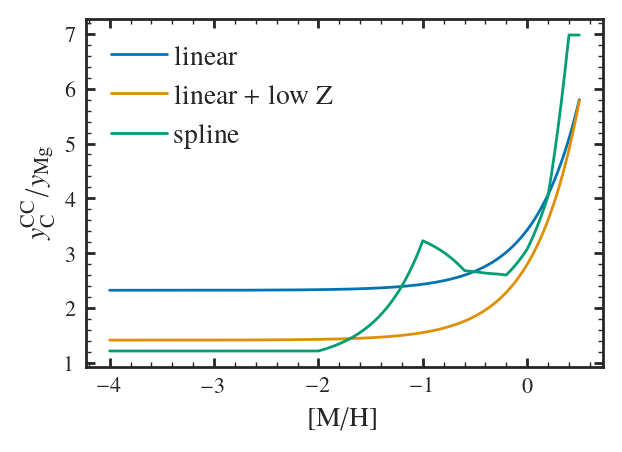

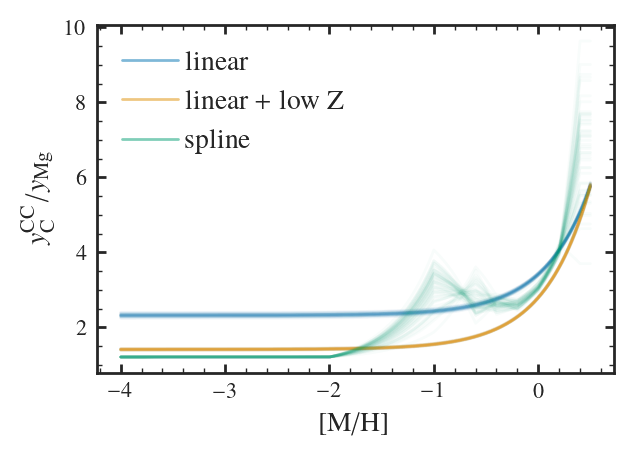

In [177]:
labels = {
    "fiducial": "linear",
    "fiducial_constrained": "linear + low Z",
    "fiducial_spline": "spline"
}


compare_y_cc_mean(labels)
plt.show()
compare_y_cc(labels)

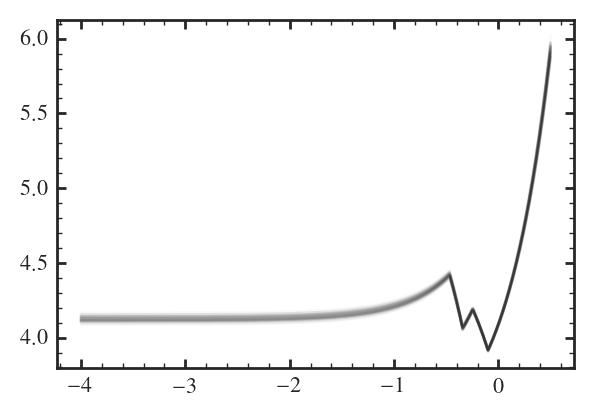

In [153]:
plot_y_tot(results["fiducial_constrained"])

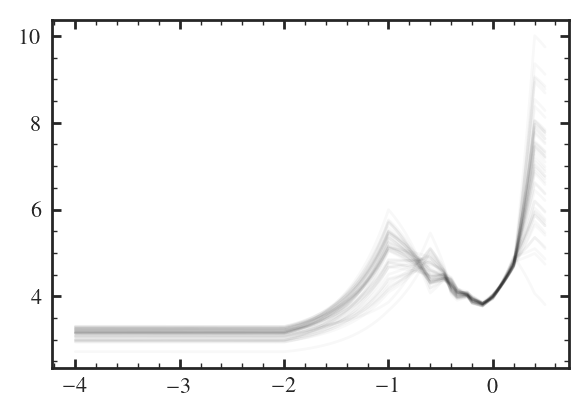

In [154]:
plot_y_tot(results["fiducial_spline"])

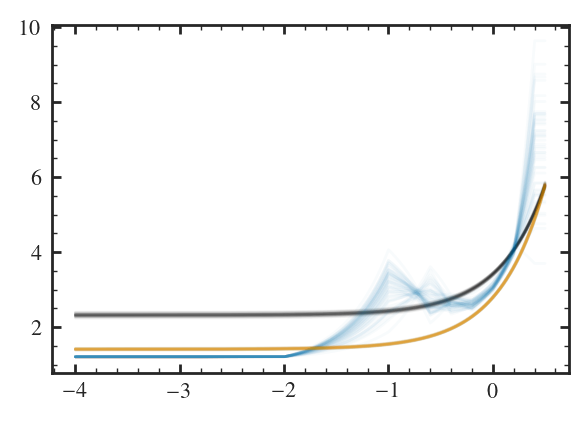

In [158]:

plot_y_cc(results["fiducial"])
plot_y_cc(results["fiducial_spline"], color=arya.COLORS[0])
plot_y_cc(results["fiducial_constrained"], color=arya.COLORS[1])


In [46]:
def plot_ana(y0, slope, **kwargs):
    x = np.linspace(-1, 0.5, 1000)
    Z = gcem.MH_to_Z(x)

    y_model = np.vectorize(surp.yield_models.Lin_CC(slope = slope / surp.Z_SUN, y0=y0))

    y = y_model(Z)

    plt.plot(x, y / y_mg, **kwargs)

In [121]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
   # "analytic": r"analytic",    
    "fiducial_constrained": r"FRUITY + gas",

    "fruity_m0.7": r"FRUITY m0.7",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
}

warning, no agb for  fiducial_constrained


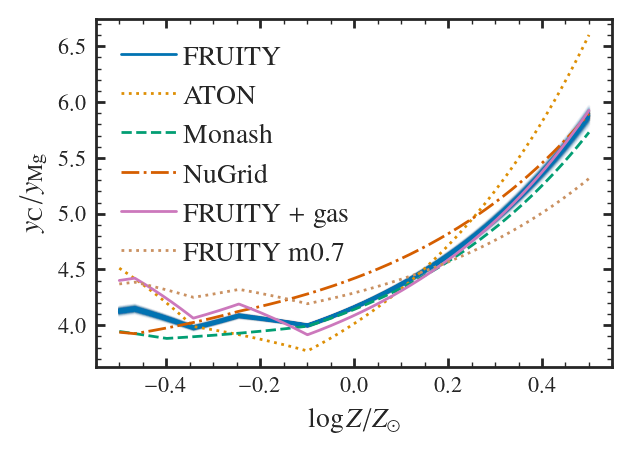

In [122]:

plt.figure()
plot_y_tot(results["fiducial"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

# plot_ana(2.7e-3, 0.35e-3, color="black")
# plot_ana(3.1e-3, 0.35e-3, color="black")

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.legend()
plt.savefig("figures/mcmc_y_tot.pdf")